# ガウス尺度混合モデル (Gaussian scale mixture model)
## 神経活動の変動性による不確実性の表現

神経活動の変動性 (neural variability)




{cite:p}`Shimazaki2019-yx`, {cite:p}`Shimazaki2020-kx`,  {cite:p}`Orban2016-tm`, {cite:p}`Echeveste2020-sh`, 

自発活動が事前分布であるという説 {cite:p}`Fiser2010-kw`, {cite:p}`Berkes2011-it`.

## ガウス尺度混合モデル
**ガウス尺度混合 (Gaussian scale mixture; GSM) モデル**は確率的生成モデルの一種である{cite:p}`Wainwright1999-cl`．GSMモデルでは入力を次式で予測する：

$$
\text{入力}={z}\left(\sum \text{神経活動} \times \text{基底} \right) + \text{ノイズ}
$$

前節までのスパース符号化モデル等と同様に，入力が基底の線形和で表されるとしている．ただし，尺度(scale)パラメータ$z$が基底の線形和に乗じられている点が異なる．

```{note}
コードは{cite:p}`Orban2016-tm` <https://github.com/gergoorban/sampling_in_gsm>, および{cite:p}`Echeveste2020-sh` <https://bitbucket.org/RSE_1987/ssn_inference_numerical_experiments/src/master/>を参考に作成した．
```


### 事前分布
$\mathbf{x} \in \mathbb{R}^{N_x}$, $\mathbf{A} \in \mathbb{R}^{N_x\times N_y}$, $\mathbf{y} \in \mathbb{R}^{N_y}$, $\mathbf{z} \in \mathbb{R}$とする．

$$
p\left(\mathbf{x}\mid\mathbf{y}, z\right)=\mathcal{N}\left(z \mathbf{A} \mathbf{y}, \sigma_{\mathbf{x}}^{2} \mathbf{I}\right)
$$

事前分布を

$$
\begin{aligned}
p\left(\mathbf{y}\right)&=\mathcal{N}\left(\mathbf{0}, \mathbf{C}\right)\\
p\left(z\right)&=\Gamma (k, \vartheta)
\end{aligned}
$$

とする．$\Gamma(k, \vartheta)$はガンマ分布であり，$k$は形状(shape)パラメータ，$\vartheta$は尺度(scale)パラメータである．$p\left(\mathbf{y}\right)$は$\mathbf{y}$の事前分布であり，刺激がない場合の自発活動の分布を表していると仮定する．

### 重み行列$\mathbf{A}$の作成

In [1]:
using PyPlot, LinearAlgebra, Random, Distributions
using PyPlot: matplotlib
Random.seed!(2)
rc("axes.spines", top=false, right=false)

In [2]:
function gabor(x, y, θ, σ=1, λ=2, ψ=0)
    xθ = x * cos(θ) + y * sin(θ)
    yθ = -x * sin(θ) + y * cos(θ)
    return exp(-.5(xθ^2 + yθ^2)/σ^2) * cos(2π/λ * xθ + ψ)
end;

In [3]:
L = 16   # width/height of input image
Nx = L^2 # dimension of the observed variable x
Ny = 50  # dimension of the hidden variable y

A = zeros(Nx, Ny) # weight matrix
p = range(-3, 3, length=L) # position
θg = (1:Ny) / Ny * π # theta for gabor
for i in 1:Ny
    gb = gabor.(p', p, θg[i])
    gb /= norm(gb) + 1e-8 # normalization
    A[:, i] = gb[:] # flatten and save
end;

In [4]:
# sampling from p(x|y, z)
function sampling_x(y, z, A, σₓ)
    μₓ = z*A*y
    noise = σₓ * randn(size(μₓ))
    return μₓ + noise
end;

### 分散共分散行列$\mathbf{C}$の作成
$\mathbf{C}$は$y$の事前分布の分散共分散行列である．{cite:p}`Orban2016-tm`では自然画像を用いて作成しているが，ここでは簡単のため$\mathbf{A}$と同様に{cite:p}`Echeveste2020-sh`に従って作成する．前項で作成した通り，$\mathbf{A}$の各基底には周期性があるため，類似した基底を持つニューロン同士は類似した出力をすると考えられる．Echevesteらは$\theta\in[-\pi/2, \pi/2)$の範囲においてFourier基底を複数作成し，そのグラム行列(Gram matrix)を係数倍したものを$\mathbf{C}$と設定している．ここではガウス過程(Gaussian process)モデルとの類似性から，周期カーネル(periodic kernel) 

$$
K(\theta, \theta')=\exp\left[\phi_1 \cos \left(\dfrac{|\theta-\theta'|}{\phi_2}\right)\right]
$$

を用いる．ここでは$|\theta-\theta'|=m\pi\ (m=0,1,\ldots)$の際に類似度が最大になればよいので，$\phi_2=0.5$とする．これが正定値行列になるように単位行列の係数倍$\epsilon\mathbf{I}$を加算し，スケーリングした上で，`Symmetric(C)`や`Matrix(Hermitian(C)))`により実対象行列としたものを$\mathbf{C}$とする．$\mathbf{C}$を正定値行列にする理由はJuliaの`MvNormal`がCholesky分解を用いて多変量正規分布の乱数を生成するためである． 事前に`cholesky(C)`が実行できるか確認するのもよい．

In [5]:
K(x₁, x₂, ψ₁, ψ₂) = exp(ψ₁ * cos(abs(x₁-x₂) / ψ₂)) # periodic kernel
C = K.(θg', θg, 2.0, 0.5) # create covariance matrix
C += 0.1 * I # regularization to make C positive definite
C_min, C_max = minimum(C), maximum(C)
C_range = [-0.5, 4.0] # target min-max of C
C = C_range[1] .+ (C_range[2]-C_range[1]) * (C .- C_min) / (C_max - C_min);
C = Symmetric(C); # make symmetric matrix using upper triangular matrix

50×50 Symmetric{Float64, Matrix{Float64}}:
 4.0        3.86806     3.66344    …   3.34634     3.66344     3.86806
 3.86806    4.0         3.86806        2.94784     3.34634     3.66344
 3.66344    3.86806     4.0            2.50327     2.94784     3.34634
 3.34634    3.66344     3.86806        2.04672     2.50327     2.94784
 2.94784    3.34634     3.66344        1.60678     2.04672     2.50327
 2.50327    2.94784     3.34634    …   1.20416     1.60678     2.04672
 2.04672    2.50327     2.94784        0.851129    1.20416     1.60678
 1.60678    2.04672     2.50327        0.552493    0.851129    1.20416
 1.20416    1.60678     2.04672        0.307333    0.552493    0.851129
 0.851129   1.20416     1.60678        0.111       0.307333    0.552493
 0.552493   0.851129    1.20416    …  -0.0430993   0.111       0.307333
 0.307333   0.552493    0.851129      -0.16214    -0.0430993   0.111
 0.111      0.307333    0.552493      -0.252981   -0.16214    -0.0430993
 ⋮                             

ここでPref. oriは最適方位 (preferred orientation)を意味する．

### 事後分布の計算
事後分布は$z$と$\mathbf{y}$のそれぞれについて次のように求められる．


$$
\begin{aligned}
p(z \mid \mathbf{x}) &\propto p(z) \mathcal{N}\left(0, z^{2} \mathbf{A C A}^{\top}+\sigma_{x}^{2} \mathbf{I}\right)\\
p(\mathbf{y} \mid z, \mathbf{x})& = \mathcal{N}\left(\mu(z, \mathbf{x}), \Sigma(z)\right)
\end{aligned}
$$

ただし，

$$
\begin{aligned}
\Sigma(z)&=\left(\mathbf{C}^{-1}+\frac{z^{2}}{\sigma_{x}^{2}} \mathbf{A}^{\top} \mathbf{A}\right)^{-1}\\
\mu(z, \mathbf{x})&=\frac{z}{\sigma_{x}^{2}} \Sigma(z) \mathbf{A}^{\top} \mathbf{x}
\end{aligned}
$$

である．

最終的な予測において$z$の事後分布は必要でないため，$p(\mathbf{y} \mid z, \mathbf{x})$から$z$を消去することを考えよう．厳密に行う場合，次式のように周辺化(marginalization)により，$z$を（積分）消去する必要がある．

$$
p(\mathbf{y} \mid \mathbf{x}) = \int dz\ p(z\mid \mathbf{x})\cdot p(\mathbf{y} \mid z, \mathbf{x})
$$

周辺化においては，まず$z$のMAP推定（最大事後確率推定）値 $z_{\mathrm{MAP}}$を求める．

$$
z_{\mathrm{MAP}} = \underset{z}{\operatorname{argmax}} p(z\mid \mathbf{x})
$$

次に$z_{\mathrm{MAP}}$の周辺で$p(z\mid \mathbf{x})$を積分し，積分値が一定の閾値を超える$z$の範囲を求め，この範囲で$z$を積分消去してやればよい．しかし，$z$は単一のスカラー値であり，この手法で推定するのは煩雑であるために近似手法が{cite:p}`Echeveste2017-wu`において提案されている．Echevesteらは第一の近似として，$z$の分布を$z_{\mathrm{MAP}}$でのデルタ関数に置き換える，すなわち，$p(z\mid \mathbf{x})\simeq \delta (z-z_{\mathrm{MAP}})$とすることを提案している．この場合，$z$は定数とみなせ，$p(\mathbf{y} \mid \mathbf{x})\simeq p(\mathbf{y} \mid \mathbf{x}, z=z_{\mathrm{MAP}})$となる．第二の近似として，$z_{\mathrm{MAP}}$を真のコントラスト$z^*$で置き換えることが提案されている．GSMへの入力$\mathbf{x}$は元の画像を$\mathbf{\tilde x}$とすると，$\mathbf{x}=z^* \mathbf{\tilde x}$としてスケーリングされる．この入力の前処理の際に用いる$z^*$を用いてしまおうということである．この場合，$p(\mathbf{y} \mid \mathbf{x})\simeq p(\mathbf{y} \mid \mathbf{x}, z=z^*)$となる．しかし，入力を任意の画像とする場合，$z^*$は未知である．簡便さと精度のバランスを取り，ここでは第一の近似，$z=z_{\mathrm{MAP}}$とする手法を用いることにする．

In [6]:
# log pdf of p(z)
log_Pz(z, k, θ) = logpdf.(Gamma(k, θ), z)

# pdf of p(z|x)
function Pz_x(z_range, x, ACAᵀ, σₓ², k, θ)
    n_contrasts = length(z_range)
    log_p = zeros(n_contrasts)
    μxz = zeros(size(x))
    dz = z_range[2] - z_range[1]
    for i in 1:n_contrasts
        Cxz = z_range[i]^2 * ACAᵀ + σₓ² * I
        log_p[i] = log_Pz(z_range[i], k, θ) + logpdf(MvNormal(μxz, Symmetric(Cxz)), x)
    end
    p = exp.(log_p .- maximum(log_p)) # for numerical stability
    p /= sum(p) * dz
    return p
end;

In [7]:
# mean and covariance matrix of p(y|x, z)
function post_moments(x, z, σₓ², A, AᵀA, C⁻¹)
    Σz = inv(C⁻¹ + (z^2 / σₓ²) * AᵀA)
    μzx = (z/σₓ²) * Σz * A' * x
    return μzx, Σz
end;

### シミュレーション

In [8]:
AᵀA = A' * A
ACAᵀ = A * C * A'

σₓ = 1.0 # Noise of the x process
σₓ² = σₓ^2
k, θ = 2.0, 2.0 # Parameter of the gamma dist. for z (Shape, Scale)

C⁻¹ = inv(C); # We will need the inverse of C

入力データの作成

In [9]:
Z = [0.0, 0.25, 0.5, 1.0, 2.0] # set true contrasts z^*
n_samples = size(Z)[1]
y = rand(MvNormal(zeros(Ny), Symmetric(C)), 1) # sampling from P(y)=N(0, C)
X = hcat(map((z) -> sampling_x(y, z, A, σₓ), Z)...)';

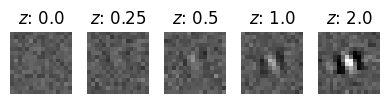

In [10]:
x_min, x_max = minimum(X), maximum(X)

figure(figsize=(4,2))
for s in 1:n_samples
    subplot(1, n_samples, s)
    title(L"$z$: "*string(Z[s]))
    imshow(reshape(X[s, :], 16, 16), vmin=x_min, vmax=x_max, cmap="gray")
    axis("off")
end
tight_layout()

事後分布の計算をする．

In [11]:
μ_post = zeros(n_samples, Ny)
σ_post = zeros(n_samples, Ny)
Σ_post = zeros(n_samples, Ny, Ny)

z_range = range(0, 5.0, length=100) # range of z for MAP estimation
Z_MAP = zeros(n_samples) 

for s in 1:n_samples
    p_z = Pz_x(z_range, X[s, :], ACAᵀ, σₓ², k, θ)
    Z_MAP[s] = z_range[argmax(p_z)] # MAP estimated z
    μ_post[s, :], Σ_post[s, :, :] = post_moments(X[s, :], Z_MAP[s], σₓ², A, AᵀA, C⁻¹)
    σ_post[s, :] = sqrt.(diag(Σ_post[s, :, :]))
end

### 結果

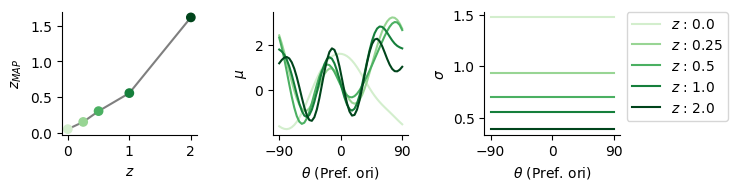

In [12]:
θs = range(-90, 90, length=Ny)
cm = get_cmap(:Greens) # get color map
cms = cm.((1:n_samples)/n_samples) # color list

fig, ax = subplots(1, 3, figsize=(7.5, 2))
ax[1].scatter(Z, Z_MAP, c=cms)
ax[1].plot(Z, Z_MAP, color="tab:gray", zorder=0)
ax[1].set_xlabel(L"$z$"); ax[1].set_ylabel(L"$z_{MAP}$"); 
for s in 1:n_samples
    ax[2].plot(θs, μ_post[s, :], color=cms[s])
    ax[3].plot(θs, σ_post[s, :], color=cms[s], label=L"$z$ : "*string(Z[s]))
end
ax[2].set_ylabel(L"$\mu$"); ax[3].set_ylabel(L"$\sigma$")
for i in 2:3
    ax[i].set_xticks([-90,0,90])
    ax[i].set_xlabel(L"$\theta$ (Pref. ori)")
end
ax[3].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
tight_layout()

In [13]:
fig, ax = subplots(1, n_samples, figsize=(7.5, 1), sharex="all", sharey="all")
for s in 1:n_samples
    ax[s].set_title(L"$z$ : "*string(Z[s]))
    ims = ax[s].imshow(Σ_post[s, :, :], origin="lower", cmap="bwr", extent=(-90, 90, -90, 90), vmin=-1, vmax=1)
    ax[s].set_xticks([-90,0,90]); ax[s].set_yticks([-90,0,90]);
    if s == 1
        ax[s].set_ylabel(L"$\theta$ (Pref. ori)")
    elseif s == ceil(Int, n_samples/2) 
        ax[s].set_xlabel(L"$\theta$ (Pref. ori)"); 
    end
end
fig.colorbar(ims, ax=ax[n_samples]);

LoadError: UndefVarError: ims not defined

### 出力のサンプリング

In [14]:
membrane_potential(y, α=2.4, β=1.9, γ=0.6) = α * max(0, y+β)^γ

function low_pass_filter(x, η=0.2)
    x_filtered = zeros(size(x)) # num. of neuron, time steps
    x_filtered[:, 1] = x[:, 1]
    for t in 1:size(x)[2]-1
        x_filtered[:, t+1] = (1-η) * x_filtered[:, t] + η * x[:, t+1]
    end
    return x_filtered
end;

事後分布から応答をサンプリングする．フィルタリングするのは自己相関を上げるため．

In [50]:
nt = 100
u = zeros(n_samples, Ny, nt)
for s in 1:n_samples
    μ = μ_post[s, :]
    Σ = Σ_post[s, :, :]
    sample = rand(MvNormal(μ, Symmetric(Σ)), nt)
    u[s, :, :] = low_pass_filter(membrane_potential.(sample))
end

In [16]:
# modified from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
function confidence_ellipse(x, y, ax, n_std=3, alpha=1, facecolor="none", edgecolor="tab:gray")
    pearson = cor(x,y)
    rx, ry = sqrt(1 + pearson), sqrt(1 - pearson)
    ellipse = matplotlib.patches.Ellipse((0, 0), width=2*rx, height=2*ry, alpha=alpha, 
        fc=facecolor, ec=edgecolor, lw=2, zorder=0)
    scales = [std(x), std(y)] * n_std
    means = [mean(x), mean(y)]
    transf = matplotlib.transforms.Affine2D().rotate_deg(45).scale(scales...).translate(means...)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
end;

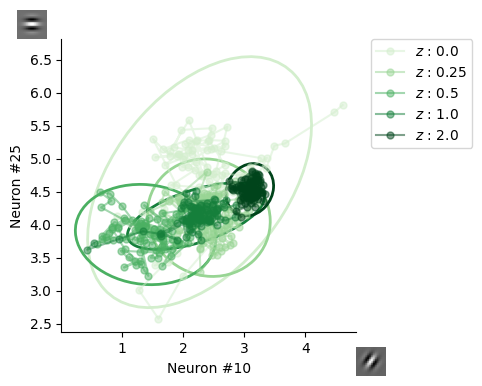

In [17]:
fig, ax = subplots(figsize=(5, 4))
unit_idx = [10, 25]
for s in 1:n_samples
    u₁, u₂ = u[s, unit_idx[1], :], u[s, unit_idx[2], :]
    ax.plot(u₁, u₂, marker="o", markersize=5, alpha=0.5, color=cms[s], label=L"$z$ : "*string(Z[s]))
    confidence_ellipse(u₁, u₂, ax, 3, 1, "none", cms[s])
end
ax.set_xlabel("Neuron #"*string(unit_idx[1])); ax.set_ylabel("Neuron #"*string(unit_idx[2]))
axins = [ax.inset_axes([1, -0.15,0.1,0.1]), ax.inset_axes([-0.15,1,0.1,0.1])]
for i in 1:2
    axins[i].imshow(reshape(A[:,unit_idx[i]], L, L), cmap="gray")
    axins[i].axis("off")
end
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
tight_layout()

## 神経活動のサンプリング仮説
Neural sampling

bayesian brain without probability {cite:p}`Sanborn2016-en`


neural sampling

In [18]:
using ForwardDiff

In [19]:
x = X[5, :]
z = Z[5];

In [20]:
dt = 0.01 # ms
τ, τl = 10.0, 150.0 # ms
α_in = [1/τ - 1/τl, 1/τ + 1/τl]
α_ext = [1/τl, -1/τ]
ρ = sqrt(2*dt/τl);

nt = 50000
M = cat(ones(1,1), C; dims=(1,2));

In [21]:
function ∇ᵤlogP(u, x, σₓ², A, C⁻¹)
    z, y = abs(u[1]), u[2:end]
    pred_error = A' * (x - z*A*y) / σₓ² # prediction error signal
    du = zeros(size(u))
    du[1] = sign(u[1]) * (y' * pred_error - z)
    du[2:end] = z * pred_error - C⁻¹*y
    return du
end

∇ᵤlogP (generic function with 1 method)

In [22]:
u, v = zeros(nt, Ny+1), zeros(nt, Ny+1)
u[1, 1] = 1

for t in 1:nt-1
    I_ext = ∇ᵤlogP(u[t, :], x, σₓ², A, C⁻¹) # external input
    I_in = M * (u[t, :] - v[t, :])          # internal input
    u[t+1, :] = u[t, :] + dt * (α_in[1] * I_in + α_ext[1] * I_ext) + ρ * randn(Ny+1) 
    v[t+1, :] = v[t, :] + dt * (α_in[2] * I_in + α_ext[2] * I_ext) + ρ * randn(Ny+1)
end

In [23]:
using KernelDensity

In [40]:
uIE = membrane_potential.(u[1:100:nt, :]);

In [42]:
u₁, u₂ = uIE[300:end, unit_idx[1]], uIE[300:end, unit_idx[2]];
#scatter(u₁, u₂)

In [43]:
U = kde((u₁, u₂));

In [44]:
size(U.density)

(256, 256)

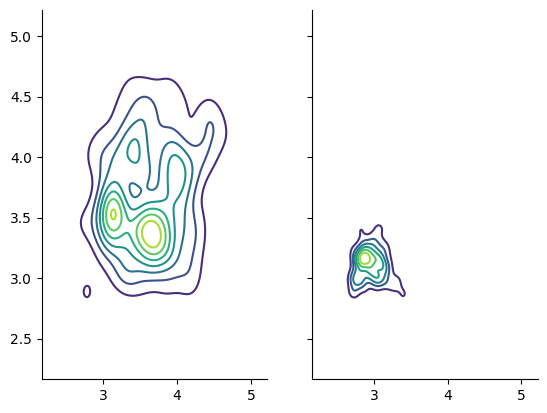

PyObject <matplotlib.contour.QuadContourSet object at 0x0000000000F32B20>

In [54]:
fig, ax = plt.subplots(1,2, sharey="all", sharex="all")
ax[1].contour(U.x, U.x, U.density)
ax[2].contour(U2.x, U2.x, U2.density)
#ax.clabel(CS, inline=true, fontsize=10)

In [52]:
U2 = kde((u[5, unit_idx[1], :], u[5, unit_idx[2], :]));

In [ ]:
plot(U.x, U.density)

In [55]:
plot(u[1:100:nt, 1])

LoadError: BoundsError: attempt to access 5×50×100 Array{Float64, 3} at index [1:100:1, 1]

In [ ]:
u₁, u₂ = uIE[300:end, unit_idx[1]], uIE[300:end, unit_idx[2]]
scatter(u₁, u₂)
#ax.plot(u₁, u₂, marker="o", markersize=5, alpha=0.5, color=cms[s], label=L"$z$ : "*string(Z[s]))    

## 参考文献
```{bibliography}
:filter: docname in docnames
```